In [ ]:
## 라이브러리 설치
!pip install matplotlib
!pip install seaborn
!pip install -q xgboost
!pip install graphviz
!pip install -q ipywidgets
!pip install -q geopandas
!pip install geopy
!pip install haversine
!pip install swifter

##### 추가된 모듈 설치 #########
!pip install -q pandarallel # 데이터프레임 병렬처리

In [1]:
## 라이브러리 불러오기 
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
from datetime import datetime
import os
import warnings
import ipywidgets as widgets
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from ipywidgets import interact, interact_manual
from geopy import distance
import geopandas as gpd
import multiprocessing
from tqdm import trange,tqdm_notebook,tqdm
from pandarallel import pandarallel

warnings.filterwarnings("ignore",category=np.VisibleDeprecationWarning)
warnings.filterwarnings('ignore')

# 차트 한글 폰트 설정
# plt.rcParams['font.family'] = 'NanumGothicCoding'
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# 차트 음수 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# 차트 기본 사이즈 설정
plt.rcParams["figure.figsize"] = (12,9)

# 모든 컬럼 표시
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_row', 100)
pd.set_option('display.max_seq_items', None)

/usr/local/lib/python3.6/dist-packages/joblib/_multiprocessing_helpers.py:45: UserWarning: [Errno 28] No space left on device.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


# 1. 데이터 불러오기 & Feature 선택
**1-1) 공통 Feature 선택(NQI) : 7개(사용 4개)**
- 기간 : 22년 03월25일~04월30일 데이터(시간대 데이터가 있는 값)
- 지역 : 서울, 경기
- Wing 데이터와 공통점이 있는 RSRQ, RSRP, SINR, CQI를 공통 Feature로 정했다. 
  * Network ID : NR SA, NR NSA 
  * Download 속도 : DL 통합속도(1차), UL통합속도(2차)
  * RSSI : NR5G RSSI -> Wing MSTR 없음
  * RSRQ : NR5G RSRQ -> 선택
  * RSRP : NR5G RSRP -> 선택
  * SINR : NR5G SINR -> 선택
  * CQI  : NR5G CQI  -> 선택

In [35]:
## 데이터 불러오기 
##NQI_RAW
feature = ['Time', 'Longitude', 'Latitude', 'ServingNet', 'Equipment','FWD_Throughput', 'FWD_Throughput_Byte', 'NR5G DL PDCP TP',
       'NR5G UL PDCP TP', 'NR5G DL RLC TP', 'NR5G UL RLC TP', 'NR5G DL MAC TP','NR5G UL MAC TP', 'NR_PCI', 'NR_RSRP', 'NR_RSRQ',
       'NR_SINR', 'NR_BWP_PRB', 'NR_SS_SINR', 'NR_CQI', 'NR_DL_MCS','NR_UL_MCS','NR_RSSI']
path = '/tf/skj/Wing_speed/NQI_DATA_220517/'
start_time = datetime.now()
file_list = os.listdir(path)
##KDM
file_list_kdm = [file for file in file_list if file.endswith('KDM.csv')]
df_kdm = pd.DataFrame()
for i in file_list_kdm:
#     print(i)
    data = pd.read_csv(path+i,usecols=feature,encoding='cp949')
    df_kdm = pd.concat([df_kdm,data])
df_kdm = df_kdm.reset_index(drop=True)
##DML
file_list_dml = [file for file in file_list if file.endswith('DML.csv')]
df_dml = pd.DataFrame()
for i in file_list_dml:
#     print(i)
    data = pd.read_csv(path+i,usecols=feature,encoding='cp949')
    df_dml = pd.concat([df_dml,data])
df_dml = df_dml.reset_index(drop=True)
##VSNIPER
file_list_vsn = [file for file in file_list if file.endswith('VSniper.csv')]
df_vsn = pd.DataFrame()
for i in file_list_vsn:
#     print(i)
    data = pd.read_csv(path+i,usecols=feature,encoding='cp949')
    df_vsn = pd.concat([df_vsn,data])
df_vsn = df_vsn.reset_index(drop=True)
end_time = datetime.now()
print("01. KDM,DLM,VSniper 파일 가져오기 :",end_time-start_time)
print("KDM파일 :",df_kdm.shape,"DKM파일 :",df_dml.shape,"VSN파일 :",df_vsn.shape,)
##dataframe concat 
df = pd.concat([df_kdm,df_dml,df_vsn])
print(" 통합 파일 :",df.shape)
## NQI 전처리 
new_cols = {
        'Time' : 'time',
        'Equipment': 'tool',
        'ServingNet' : 'nw_mode',
        'FWD_Throughput' : 'dl_speed1',
        'FWD_Throughput_Byte': 'dl_speed2',
        'NR5G DL PDCP TP' : 'dl_pdcp_speed',
        'NR5G UL PDCP TP' : 'ul_pdcp_speed', 
        'NR5G DL RLC TP': 'dl_rlc_speed', 
        'NR5G UL RLC TP': 'ul_rlc_speed', 
        'NR5G DL MAC TP': 'dl_mac_speed',
        'NR5G UL MAC TP' : 'ul_mac_speed',
        'NR_RSRQ': 'rsrq',
        'NR_RSRP': 'rsrp',
        'NR_SINR': 'sinr',
        'NR_CQI' : 'cqi',
        'NR_PCI' : 'pci',
        'Latitude' : 'lat',
        'Longitude' : 'lon'
        }
df2 = df.rename(columns=new_cols)
df2['date'] = df2['time'].str.split().str.get(0).str.replace('-','').str[2:].astype(int)
df2['hour'] = df2['time'].str.split().str.get(1).str[0:2].astype(int)
df2['min'] = df2['time'].str.split().str.get(1).str[3:5].astype(int)
filter = (df2.nw_mode.str[0:2]=="NR")
df3 = df2.loc[filter, :]
features = ['date','hour','min','tool','nw_mode','lat','lon','dl_speed1','rsrp', 'rsrq', 'sinr','cqi','pci','dl_pdcp_speed', 'ul_pdcp_speed', 'dl_rlc_speed', 'ul_rlc_speed',
       'dl_mac_speed', 'ul_mac_speed']
df4 = df3[features]
data = df4.drop_duplicates(keep='first')
data.reset_index(drop=True,inplace=True)


01. KDM,DLM,VSniper 파일 가져오기 : 0:00:04.459910
KDM파일 : (542981, 23) DKM파일 : (121489, 23) VSN파일 : (95234, 23)
 통합 파일 : (759704, 23)


In [36]:
data.head(2)

,date,hour,min,tool,nw_mode,lat,lon,dl_speed1,rsrp,rsrq,sinr,cqi,pci,dl_pdcp_speed,ul_pdcp_speed,dl_rlc_speed,ul_rlc_speed,dl_mac_speed,ul_mac_speed
0,220415,12,28,KDM,NR NSA,37.02868,127.06871,666906.0,-86.19,-10.52,16.05,9.00,201,701.084,0.524,478.522,0.612,481.134,0.635
1,220415,12,28,KDM,NR NSA,37.02868,127.06871,675954.0,-84.79,-10.48,16.21,9.58,201,739.836,0.512,523.313,0.602,525.672,0.639


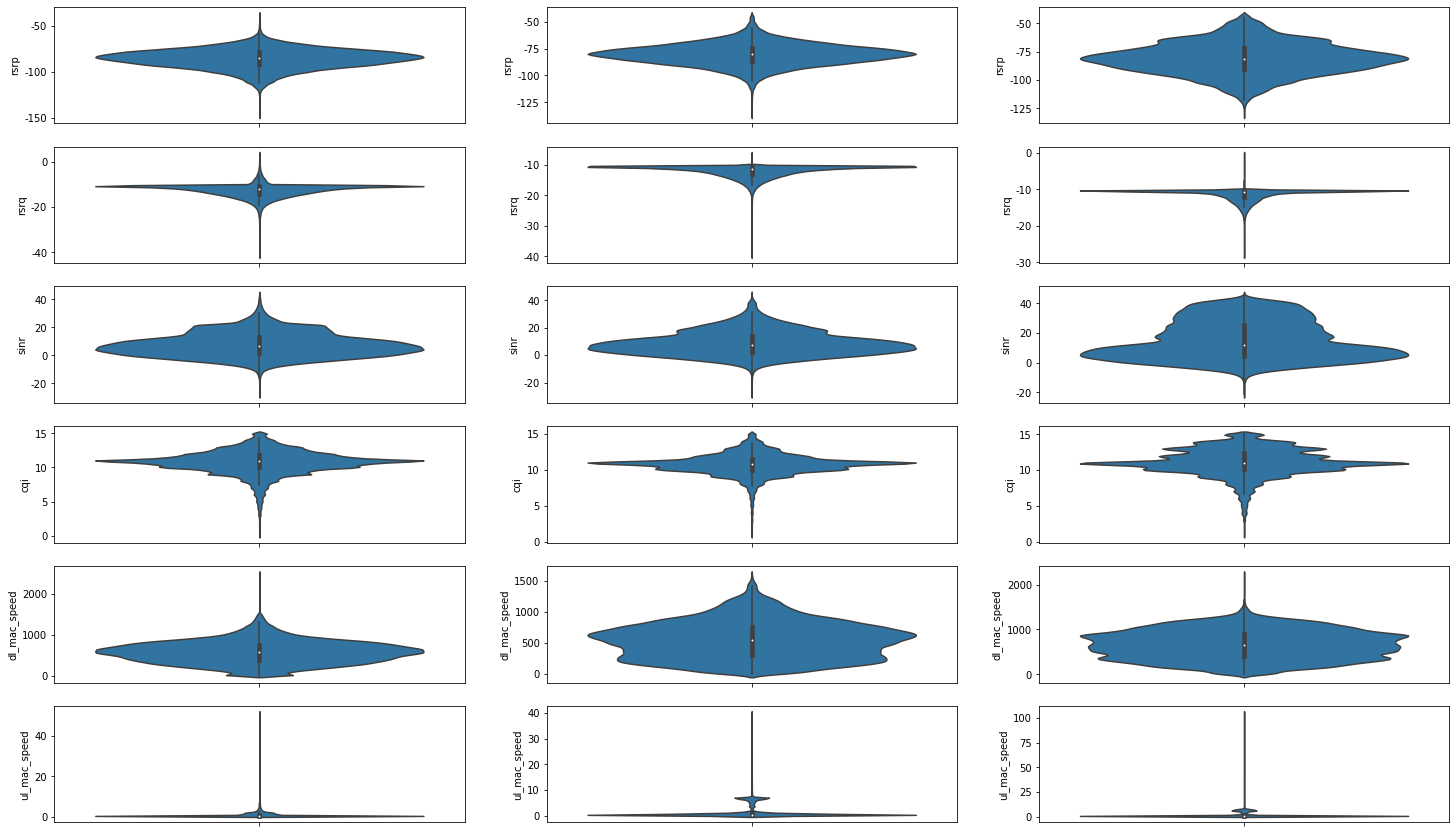

In [12]:
fig,axs = plt.subplots(figsize=(25,15), ncols=3,nrows=6)
features = ['rsrp','rsrq','sinr','cqi','dl_mac_speed','ul_mac_speed']
tables = [data[data.tool=="KDM"],data[data.tool=="DML"],data[data.tool=="V-Sniper"]]
for i, feature in enumerate(features):
    row = i%6
    for j,table in enumerate(tables): 
        col = j%3
        sns.violinplot(y=feature, data=table, ax=axs[row][col])


**1-2) 추가 Feature 선택(NMS,USM) : 8개(사용 5개)**
 - 기간 : 22년 3월 한달 , 일별
 - 지역 : 경기, 인천
 - 비고 : 최대한 NQI데이터와 비슷한 날짜로 해야함. 날짜 매핑 필요. 원래라면 시간대로 해야할텐데...
 - 속도에 영향있는  Feature 발굴 필요
 - 32T만 해야할듯....
  * dist : 기지국과 POT 사이의 거리 
  * Rank_index : 기지국 파라미터(RI를 최대한 얼마나 사용할 것인가?)
  * hpw, vpw : 수직/수평 빔폭, 빔폭을 어떻게 하느냐에 따라 빔 패턴이 달라진다.
  * RU_TYPE : 기지국 Type(32T/8T/4T) 안테나 개수, 커버리지에 따라 다르다. 속도 역시 달라질 것으로 추정
  * DL, UL PRB : PRB부하율... 이거는 일단위 보다는 그 시간대 5분부하율로 보고싶다...
  * DL, UL BLER : Block error rate... 이거는 일단위 보다는 그 시간대 5분부하율로 보고싶다...
  * DL_MCS_Layer: RI * MCS 가장 중요한 Feature로 판단됨.
  * SCG_RATE : ERAB대비 SCG 사용량. 아무래도 SCG가 많은 지역은 속도가 저하될 것으로 추정.

In [37]:
#Siteinfo
sdf = pd.read_csv('/tf/skj/Wing_speed/220527_정리/2205_siteinfo.csv', encoding='cp949')
#USM_statistics
tdf = pd.read_csv('/tf/skj/Wing_speed/220527_정리/2205_site_stat.csv')
#dong별주소매핑
ddf = pd.read_csv('/tf/skj/Wing_speed/220527_정리/dong_lat_lon_행안부_ver2.csv')

# print('-'*50)
# df['pci'] = np.round(df['pci'],0).astype(int)
## 통계 전처리 
## 09~18시 통계 시간대 평균으로 맞추기 
# agg_format= {'ErabAddAtt':'mean','scg_sum':'mean', 'UL_PRB':'mean', 'DL_PRB':'mean', 'ConnEstabAtt':'mean','Redirection':'mean', 'ul_bler':'mean', 'dl_bler':'mean', 'RssiOverPathAvg':'mean', 'dl_mcs':'mean',
#        'layer_num':'mean', 'dl_mcs_layer':'mean'}
# tdf2 = tdf.groupby(['Day','gnodeb_id','NE_ID','cell_id']).agg(agg_format).reset_index()
# tdf2['date'] = ('22'+tdf2.Day.str[0:2]+tdf2.Day.str[3:5]).astype(int)
# tdf2.rename(columns={'gnodeb_id':'gnb_id','cell_id':'cellid'},inplace=True)
# tdf2.head(1)
# print('통계 전처리(일별로 통계 SUM) 후 데이터 확인 :',tdf2.shape)
# print('일별로 평균 통계 데이터 확인 :',tdf2.shape)

#주소정제
#주소 정제 후 NQI 데이터와 매핑 -> 동을 알아내서 PCI를 가지고 있는 기지국 찾아내기. 

data['lat_mod'] = np.floor(data.lat*100)/100
data['lon_mod'] = np.floor(data.lon*100)/100
data['mon'] = np.round(data.date/100,0)
ddf['lat_mod'] = np.floor(ddf.lat*100)/100
ddf['lon_mod'] = np.floor(ddf.lon*100)/100
sdf['lat_mod'] = np.floor(sdf.LAT*100)/100
sdf['lon_mod'] = np.floor(sdf.LON*100)/100
sdf['mon'] = np.round(sdf.date/100,0)


In [38]:
import multiprocessing
from tqdm import trange,tqdm_notebook,tqdm
from pandarallel import pandarallel

start_time = datetime.now()
#NQI데이터 주소 매핑
data2 = data.dropna(subset=['rsrp','rsrq','sinr','cqi','dl_mac_speed'])
data_addr = pd.merge(data2, ddf,  how='left', left_on=['lat_mod','lon_mod'], right_on = ['lat_mod','lon_mod'])
#Site데이터 주소 매핑 
sdf_addr = pd.merge(sdf, ddf,  how='left', left_on=['lat_mod','lon_mod'], right_on = ['lat_mod','lon_mod'])
data_addr.dropna(subset=['si_gu','dong'],inplace=True)
sdf_addr.dropna(subset=['si_gu','dong'],inplace=True)
data_addr.reset_index(drop=True,inplace=True)
sdf_addr.reset_index(drop=True,inplace=True)
end_time = datetime.now()
print("소요시간 : ",end_time-start_time)


start_time = datetime.now()
print("처음 데이터:",data.shape,"null값제거 : ",data2.shape,",데이터 주소매핑:",data_addr.shape)
print("siteinfo:",sdf.shape,",siteinfo+주소:",sdf_addr.shape)

sdf_addr2 =  sdf_addr[['date', 'gnb_ID', 'DU_Name', 'RRH_ID', 'CELL_ID', 'PCI',
       'RU_TYPE', 'RANK_INDEX', 'HPW', 'VPW', 'ETILT', 'LAT', 'LON', 'lat_mod',
       'lon_mod', 'mon','si_gu','dong']]
sdf_addr2.drop_duplicates(keep='first',inplace=True)
print("siteinfo 주소매핑 :",sdf_addr.shape,sdf_addr2.shape)
data_addr2 =  data_addr[['date', 'hour','min', 'tool', 'nw_mode', 'lat_x', 'lon_x', 'dl_speed1',
       'rsrp', 'rsrq', 'sinr', 'cqi', 'pci', 'dl_pdcp_speed', 'ul_pdcp_speed',
       'dl_rlc_speed', 'ul_rlc_speed', 'dl_mac_speed', 'ul_mac_speed',
       'lat_mod', 'lon_mod', 'mon','si_gu', 'dong']]
data_addr2.drop_duplicates(keep='first',inplace=True)
print("nqi데이터 주소매핑 :",data_addr.shape,data_addr2.shape)
merge_nqi_data = pd.merge(data_addr2,sdf_addr2,how='left',left_on=['mon','si_gu','pci'], right_on = ['mon','si_gu','PCI'])
merge_nqi_data.dropna(subset=['gnb_ID','PCI'],inplace=True)
merge_nqi_data2 = merge_nqi_data[['date_x', 'hour','min', 'tool', 'nw_mode', 'lat_x', 'lon_x', 'dl_speed1','dl_pdcp_speed', 'ul_pdcp_speed',
       'dl_rlc_speed', 'ul_rlc_speed', 'dl_mac_speed', 'ul_mac_speed','rsrq', 'rsrp', 'sinr', 'cqi', 'pci','si_gu','dong_x','gnb_ID', 
       'DU_Name', 'RRH_ID', 'CELL_ID','PCI', 'RU_TYPE', 'RANK_INDEX', 'HPW', 'VPW', 'ETILT', 'LAT', 'LON']]
print("데이터와 사이트결합 :",merge_nqi_data.shape,merge_nqi_data2.shape)
end_time = datetime.now()
print("소요시간 : ",end_time-start_time)

start_time = datetime.now()
#dist : 위경도 거리 차이 계산 
def dist_calc(row):
    start = (row['lat_x'], row['lon_x'])
    stop = (row['LAT'],row['LON'])
    return np.around(distance.great_circle(start,stop).m,1)
merge_nqi_data2.drop_duplicates(keep='first',inplace=True)
merge_nqi_data2['dist'] = merge_nqi_data2.apply(lambda row : dist_calc(row),axis=1)
end_time = datetime.now()
print("데이터와 사이트결합 :",merge_nqi_data.shape)
end_time = datetime.now()
print("dist계산 소요시간 : ",end_time-start_time)

#통계 데이터 합치기
start_time = datetime.now()
mdf = pd.merge(merge_nqi_data2,tdf,how='inner',left_on=['date_x','gnb_ID','CELL_ID'], right_on = ['date','gnb_id','cellid'])
#최종 결과
mdf.dropna(subset=['RU_TYPE','UL_PRB'],inplace=True)
mdf3 = mdf.drop_duplicates(keep='first')
mdf3['scg_rate'] = round((mdf3.scg_sum/mdf3.ErabAddAtt)*100,2)
mdf3['red_rate'] = round((mdf3.Redirection/mdf3.ConnEstabAtt)*100,2)
end_time = datetime.now()
print("통계데이터와 합침:",mdf.shape,",중복제거:",mdf3.shape)
print("통계merge 소요시간 : ",end_time-start_time)

소요시간 :  0:00:03.662537
처음 데이터: (753761, 22) null값제거 :  (728555, 22) ,데이터 주소매핑: (3577194, 31)
siteinfo: (62720, 16) ,siteinfo+주소: (329626, 25)
siteinfo 주소매핑 : (329626, 25) (96701, 18)
nqi데이터 주소매핑 : (3577194, 31) (1073371, 24)
데이터와 사이트결합 : (2790407, 40) (2790407, 33)
소요시간 :  0:00:06.454812
데이터와 사이트결합 : (2790407, 40)
dist계산 소요시간 :  0:00:44.372387
통계데이터와 합침: (943263, 52) ,중복제거: (943263, 54)
통계merge 소요시간 :  0:00:03.523109


In [39]:
mdf3[100:110]

,date_x,hour,min,tool,nw_mode,lat_x,lon_x,dl_speed1,dl_pdcp_speed,ul_pdcp_speed,dl_rlc_speed,ul_rlc_speed,dl_mac_speed,ul_mac_speed,rsrq,rsrp,sinr,cqi,pci,si_gu,dong_x,gnb_ID,DU_Name,RRH_ID,CELL_ID,PCI,RU_TYPE,RANK_INDEX,HPW,VPW,ETILT,LAT,LON,dist,Unnamed: 0,Day,gnb_id,NE_ID,cellid,ErabAddAtt,scg_sum,UL_PRB,DL_PRB,ConnEstabAtt,Redirection,ul_bler,dl_bler,RssiOverPathAvg,dl_mcs,layer_num,dl_mcs_layer,date,scg_rate,red_rate
100,220415,12,29,KDM,NR NSA,37.0281,127.06871,767893.0,844.283,0.594,621.046,0.698,621.187,0.718,-10.48,-82.14,15.53,10.38,229,평택시,지제동,82349.0,NS00240734,NRKG45892S,3147.0,229.0,32.0,4.0,65.0,6.0,0.0,37.0871,127.0801,6637.9,552877,04-15,82349,DU_404270049,3147.0,82.7,0.4,0.063,1.512,95.7,4.8,16.226,8.936,-92.556,5.404,2.43,13.089,220415,0.48,5.02
101,220415,12,29,KDM,NR NSA,37.0281,127.06871,733844.0,710.321,0.518,483.125,0.603,484.358,0.611,-10.40,-79.72,18.97,10.75,229,평택시,지제동,82349.0,NS00240734,NRKG45892S,3147.0,229.0,32.0,4.0,65.0,6.0,0.0,37.0871,127.0801,6637.9,552877,04-15,82349,DU_404270049,3147.0,82.7,0.4,0.063,1.512,95.7,4.8,16.226,8.936,-92.556,5.404,2.43,13.089,220415,0.48,5.02
102,220415,12,29,KDM,NR NSA,37.0281,127.06871,617270.0,586.191,0.510,370.886,0.591,375.198,0.611,-10.45,-78.37,16.43,10.55,229,평택시,지제동,82349.0,NS00240734,NRKG45892S,3147.0,229.0,32.0,4.0,65.0,6.0,0.0,37.0871,127.0801,6637.9,552877,04-15,82349,DU_404270049,3147.0,82.7,0.4,0.063,1.512,95.7,4.8,16.226,8.936,-92.556,5.404,2.43,13.089,220415,0.48,5.02
103,220415,12,29,KDM,NR NSA,37.0281,127.06871,625356.0,679.938,0.535,425.904,0.630,427.829,0.643,-10.38,-71.73,24.45,11.21,229,평택시,지제동,82349.0,NS00240734,NRKG45892S,3147.0,229.0,32.0,4.0,65.0,6.0,0.0,37.0871,127.0801,6637.9,552877,04-15,82349,DU_404270049,3147.0,82.7,0.4,0.063,1.512,95.7,4.8,16.226,8.936,-92.556,5.404,2.43,13.089,220415,0.48,5.02
104,220415,12,29,KDM,NR NSA,37.0281,127.06871,782138.0,893.572,0.560,622.849,0.645,624.609,0.699,-10.38,-73.96,24.19,10.77,229,평택시,지제동,82349.0,NS00240734,NRKG45892S,3147.0,229.0,32.0,4.0,65.0,6.0,0.0,37.0871,127.0801,6637.9,552877,04-15,82349,DU_404270049,3147.0,82.7,0.4,0.063,1.512,95.7,4.8,16.226,8.936,-92.556,5.404,2.43,13.089,220415,0.48,5.02
105,220415,12,29,KDM,NR NSA,37.0281,127.06871,815218.0,812.561,0.595,571.415,0.701,572.415,0.690,-10.45,-77.70,19.60,10.00,229,평택시,지제동,82349.0,NS00240734,NRKG45892S,3147.0,229.0,32.0,4.0,65.0,6.0,0.0,37.0871,127.0801,6637.9,552877,04-15,82349,DU_404270049,3147.0,82.7,0.4,0.063,1.512,95.7,4.8,16.226,8.936,-92.556,5.404,2.43,13.089,220415,0.48,5.02
106,220415,12,29,KDM,NR NSA,37.0281,127.06871,745620.0,722.073,0.561,521.225,0.644,521.044,0.677,-10.49,-79.35,18.88,10.92,229,평택시,지제동,82349.0,NS00240734,NRKG45892S,3147.0,229.0,32.0,4.0,65.0,6.0,0.0,37.0871,127.0801,6637.9,552877,04-15,82349,DU_404270049,3147.0,82.7,0.4,0.063,1.512,95.7,4.8,16.226,8.936,-92.556,5.404,2.43,13.089,220415,0.48,5.02
107,220415,12,29,KDM,NR NSA,37.0281,127.06871,533966.0,439.394,0.475,293.201,0.565,293.615,0.502,-10.65,-84.08,14.61,10.00,229,평택시,지제동,82349.0,NS00240734,NRKG45892S,3147.0,229.0,32.0,4.0,65.0,6.0,0.0,37.0871,127.0801,6637.9,552877,04-15,82349,DU_404270049,3147.0,82.7,0.4,0.063,1.512,95.7,4.8,16.226,8.936,-92.556,5.404,2.43,13.089,220415,0.48,5.02
108,220415,12,29,KDM,NR NSA,37.0281,127.06871,373130.0,385.922,0.391,254.949,0.456,252.507,0.479,-11.03,-84.15,11.16,9.36,229,평택시,지제동,82349.0,NS00240734,NRKG45892S,3147.0,229.0,32.0,4.0,65.0,6.0,0.0,37.0871,127.0801,6637.9,552877,04-15,82349,DU_404270049,3147.0,82.7,0.4,0.063,1.512,95.7,4.8,16.226,8.936,-92.556,5.404,2.43,13.089,220415,0.48,5.02
109,220415,12,29,KDM,NR NSA,37.0281,127.06871,352284.0,363.293,0.386,221.549,0.454,221.671,0.451,-11.62,-86.20,6.30,9.14,229,평택시,지제동,82349.0,NS00240734,NRKG45892S,3147.0,229.0,32.0,4.0,65.0,6.0,0.0,37.0871,127.0801,6637.9,552877,04-15,82349,DU_404270049,3147.0,82.7,0.4,0.063,1.512,95.7,4.8,16.226,8.936,-92.556,5.404,2.43,13.089,220415,0.48,5.02


In [40]:
##nqi 정제 데이터 추출 
# data.to_csv('./220519_preprocessing_nqi_ver2.csv')
## merge 학습데이터 추출 
mdf3.to_csv('./01_merge_nqi_data.csv')